# What predicts how for a team will advance in the NCAA Men's Basketball Tournament?

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as scs
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

from basis_expansions import NaturalCubicSpline
from dftransformers import (ColumnSelector, Identity,
                            FeatureUnion, MapFeature,
                            Intercept)
from utils import XyScaler


# from regression_helpers import (plot_univariate_smooth,
#                                 bootstrap_train,
#                                 display_coef,
#                                 plot_bootstrap_coefs,
#                                 plot_partial_depenence,
#                                 plot_partial_dependences,
#                                 predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')


# Data Loading

In [3]:
#Load the Data from 2007/2008 - 2016/2017
df_16_17 = pd.read_csv('data/2016-2017_NCAA.csv')
df_15_16 = pd.read_csv('data/2015-2016_NCAA.csv')
df_14_15 = pd.read_csv('data/2014-2015_NCAA.csv')
df_13_14 = pd.read_csv('data/2013-2014_NCAA.csv')
df_12_13 = pd.read_csv('data/2012-2013_NCAA.csv')
df_11_12 = pd.read_csv('data/2011-2012_NCAA.csv')
df_10_11 = pd.read_csv('data/2010-2011_NCAA.csv')
df_09_10 = pd.read_csv('data/2009-2010_NCAA.csv')
df_08_09 = pd.read_csv('data/2008-2009_NCAA.csv')
df_07_08 = pd.read_csv('data/2007-2008_NCAA.csv')


# Data Cleaning

In [4]:
# Convert row 0 to column names for each dataframe
df_16_17.columns = df_16_17.iloc[0]
df_15_16.columns = df_15_16.iloc[0]
df_14_15.columns = df_14_15.iloc[0]
df_13_14.columns = df_13_14.iloc[0]
df_12_13.columns = df_12_13.iloc[0]
df_11_12.columns = df_11_12.iloc[0]
df_10_11.columns = df_10_11.iloc[0]
df_09_10.columns = df_09_10.iloc[0]
df_08_09.columns = df_08_09.iloc[0]
df_07_08.columns = df_07_08.iloc[0]

In [5]:
# Drop column 0 which has been converted to column names
df_16_17_drop_0 = df_16_17.drop([0])
df_15_16_drop_0 = df_15_16.drop([0])
df_14_15_drop_0 = df_14_15.drop([0])
df_13_14_drop_0 = df_13_14.drop([0])
df_12_13_drop_0 = df_12_13.drop([0])
df_11_12_drop_0 = df_11_12.drop([0])
df_10_11_drop_0 = df_10_11.drop([0])
df_09_10_drop_0 = df_09_10.drop([0])
df_08_09_drop_0 = df_08_09.drop([0])
df_07_08_drop_0 = df_07_08.drop([0])

In [6]:
# Add season columns to all dataframes
df_16_17_drop_0['Season'] = '2016-2017'
df_15_16_drop_0['Season'] = '2015-2016'
df_14_15_drop_0['Season'] = '2014-2015'
df_13_14_drop_0['Season'] = '2013-2014'
df_12_13_drop_0['Season'] = '2012-2013'
df_11_12_drop_0['Season'] = '2011-2012'
df_10_11_drop_0['Season'] = '2010-2011'
df_09_10_drop_0['Season'] = '2009-2010'
df_08_09_drop_0['Season'] = '2008-2009'
df_07_08_drop_0['Season'] = '2007-2008'

In [7]:
# Make list of all dataframes
years = [df_16_17_drop_0,
         df_15_16_drop_0, 
         df_14_15_drop_0, 
         df_13_14_drop_0, 
         df_12_13_drop_0, 
         df_11_12_drop_0,
         df_10_11_drop_0,
         df_09_10_drop_0,
         df_08_09_drop_0,
         df_07_08_drop_0]

In [8]:
# Concatenate all dataframes
df_main = pd.concat(years)

In [9]:
df_main.shape

(3432, 35)

In [10]:
df_main.head(20)

,Rk,School,G,W,L,W-L%,SRS,SOS,W,L,...,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Season
1,1,Abilene Christian,29,13,16,.448,-11.86,-7.10,7,11,...,543,.663,222,904,408,210,83,412,631,2016-2017
2,2,Air Force,33,12,21,.364,-3.06,1.00,4,14,...,715,.717,304,1149,494,197,57,390,594,2016-2017
3,3,Akron,36,27,9,.750,3.59,-1.21,14,4,...,744,.683,357,1246,517,198,118,422,653,2016-2017
4,4,Alabama A&M,29,2,27,.069,-26.99,-11.09,2,16,...,614,.669,299,914,326,100,50,384,526,2016-2017
5,5,Alabama-Birmingham,33,17,16,.515,-1.17,-1.83,9,9,...,674,.736,321,1188,503,157,160,444,527,2016-2017
6,6,Alabama State,31,8,23,.258,-19.75,-10.75,6,12,...,634,.637,427,1188,300,150,98,488,629,2016-2017
7,7,Alabama,34,19,15,.559,11.29,7.47,10,8,...,746,.653,418,1327,390,200,141,474,664,2016-2017
8,8,Albany (NY),35,21,14,.600,-0.16,-4.69,10,6,...,647,.757,379,1257,444,178,60,416,617,2016-2017
9,9,Alcorn State,32,18,14,.563,-12.33,-10.95,13,5,...,612,.652,387,1243,425,209,115,452,610,2016-2017
10,10,American,30,8,22,.267,-10.30,-3.50,5,13,...,474,.618,204,868,339,209,73,396,548,2016-2017


In [11]:
# drop teams not in NCAA tournament
df_tourney = df_main[df_main['School'].str.contains('NCAA')]

In [12]:
# reset indexes
df_tourney = df_tourney.reset_index(drop=True)
df_tourney.shape

(671, 35)

In [13]:
# Drop play in games
df_tourney.index[(df_tourney.School == 'Coppin State NCAA') & (df_tourney.Season == '2007-2008')]

Int64Index([618], dtype='int64')

In [14]:
# Make list of play-in game losing teams
play_in_game_losers = [
df_tourney.index[(df_tourney.School == 'Coppin State NCAA') & (df_tourney.Season == '2007-2008')],
df_tourney.index[(df_tourney.School == 'Alabama State NCAA') & (df_tourney.Season == '2008-2009')],
df_tourney.index[(df_tourney.School == 'Winthrop NCAA') & (df_tourney.Season == '2009-2010')],
df_tourney.index[(df_tourney.School == 'Arkansas-Little Rock NCAA') & (df_tourney.Season == '2010-2011')],
df_tourney.index[(df_tourney.School == 'Alabama-Birmingham NCAA') & (df_tourney.Season == '2010-2011')],
df_tourney.index[(df_tourney.School == 'Alabama State NCAA') & (df_tourney.Season == '2010-2011')],
df_tourney.index[(df_tourney.School == 'Southern California NCAA') & (df_tourney.Season == '2010-2011')],
df_tourney.index[(df_tourney.School == 'Mississippi Valley State NCAA') & (df_tourney.Season == '2011-2012')],
df_tourney.index[(df_tourney.School == 'Iona NCAA') & (df_tourney.Season == '2011-2012')],
df_tourney.index[(df_tourney.School == 'Lamar NCAA') & (df_tourney.Season == '2011-2012')],
df_tourney.index[(df_tourney.School == 'University of California NCAA') & (df_tourney.Season == '2011-2012')],
df_tourney.index[(df_tourney.School == 'Liberty NCAA') & (df_tourney.Season == '2012-2013')],
df_tourney.index[(df_tourney.School == 'Middle Tennessee NCAA') & (df_tourney.Season == '2012-2013')],
df_tourney.index[(df_tourney.School == 'Long Island University NCAA') & (df_tourney.Season == '2012-2013')],
df_tourney.index[(df_tourney.School == 'Boise State NCAA') & (df_tourney.Season == '2012-2013')],
df_tourney.index[(df_tourney.School == "Mount St. Mary's NCAA") & (df_tourney.Season == '2013-2014')],
df_tourney.index[(df_tourney.School == 'Xavier NCAA') & (df_tourney.Season == '2013-2014')],
df_tourney.index[(df_tourney.School == 'Texas Southern NCAA') & (df_tourney.Season == '2013-2014')],
df_tourney.index[(df_tourney.School == 'Iowa NCAA') & (df_tourney.Season == '2013-2014')],
df_tourney.index[(df_tourney.School == 'Manhattan NCAA') & (df_tourney.Season == '2014-2015')],
df_tourney.index[(df_tourney.School == 'Brigham Young NCAA') & (df_tourney.Season == '2014-2015')],
df_tourney.index[(df_tourney.School == 'North Florida NCAA') & (df_tourney.Season == '2014-2015')],
df_tourney.index[(df_tourney.School == 'Boise State NCAA') & (df_tourney.Season == '2014-2015')],
df_tourney.index[(df_tourney.School == 'Fairleigh Dickinson NCAA') & (df_tourney.Season == '2015-2016')],
df_tourney.index[(df_tourney.School == 'Vanderbilt NCAA') & (df_tourney.Season == '2015-2016')],
df_tourney.index[(df_tourney.School == 'Southern NCAA') & (df_tourney.Season == '2015-2016')],
df_tourney.index[(df_tourney.School == 'Tulsa NCAA') & (df_tourney.Season == '2015-2016')],
df_tourney.index[(df_tourney.School == 'New Orleans NCAA') & (df_tourney.Season == '2016-2017')],
df_tourney.index[(df_tourney.School == 'Wake Forest NCAA') & (df_tourney.Season == '2016-2017')],
df_tourney.index[(df_tourney.School == 'North Carolina Central NCAA') & (df_tourney.Season == '2016-2017')],
df_tourney.index[(df_tourney.School == 'Providence NCAA') & (df_tourney.Season == '2016-2017')],
]

In [15]:
play_in_game_losers

[Int64Index([618], dtype='int64'),
 Int64Index([542], dtype='int64'),
 Int64Index([537], dtype='int64'),
 Int64Index([412], dtype='int64'),
 Int64Index([409], dtype='int64'),
 Int64Index([410], dtype='int64'),
 Int64Index([458], dtype='int64'),
 Int64Index([374], dtype='int64'),
 Int64Index([359], dtype='int64'),
 Int64Index([364], dtype='int64'),
 Int64Index([344], dtype='int64'),
 Int64Index([299], dtype='int64'),
 Int64Index([307], dtype='int64'),
 Int64Index([300], dtype='int64'),
 Int64Index([276], dtype='int64'),
 Int64Index([238], dtype='int64'),
 Int64Index([271], dtype='int64'),
 Int64Index([259], dtype='int64'),
 Int64Index([225], dtype='int64'),
 Int64Index([167], dtype='int64'),
 Int64Index([143], dtype='int64'),
 Int64Index([175], dtype='int64'),
 Int64Index([142], dtype='int64'),
 Int64Index([82], dtype='int64'),
 Int64Index([126], dtype='int64'),
 Int64Index([116], dtype='int64'),
 Int64Index([124], dtype='int64'),
 Int64Index([33], dtype='int64'),
 Int64Index([62], dtyp

In [16]:
#Drop play-in game losers from data frame
df_tourney_no_play_in = df_tourney.drop([int(i[0]) for i in play_in_game_losers])


In [17]:
# Create new column 'Tournament_Wins'
df_tourney_no_play_in['Tournament_Wins'] = 0

In [18]:
df_tourney_no_play_in = df_tourney_no_play_in.reset_index(drop=True)

In [19]:
# for i in range(0,639):
#    print(f"df_tourney_no_play_in.loc[{i}, 'Tournament_Wins'] = 0")

# df_tourney_no_play_in.loc[0, 'Tournament_Wins'] = 0
# df_tourney_no_play_in.loc[1, 'Tournament_Wins'] = 0

In [20]:
df_tourney_no_play_in.loc[0, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[1, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[2, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[3, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[4, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[5, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[6, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[7, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[8, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[9, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[10, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[11, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[12, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[13, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[14, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[15, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[16, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[17, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[18, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[19, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[20, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[21, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[22, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[23, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[24, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[25, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[26, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[27, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[28, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[29, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[30, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[31, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[32, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[33, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[34, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[35, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[36, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[37, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[38, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[39, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[40, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[41, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[42, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[43, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[44, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[45, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[46, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[47, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[48, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[49, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[50, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[51, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[52, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[53, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[54, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[55, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[56, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[57, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[58, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[59, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[60, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[61, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[62, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[63, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[64, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[65, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[66, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[67, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[68, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[69, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[70, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[71, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[72, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[73, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[74, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[75, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[76, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[77, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[78, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[79, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[80, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[81, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[82, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[83, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[84, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[85, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[86, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[87, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[88, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[89, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[90, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[91, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[92, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[93, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[94, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[95, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[96, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[97, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[98, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[99, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[100, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[101, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[102, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[103, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[104, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[105, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[106, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[107, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[108, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[109, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[110, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[111, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[112, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[113, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[114, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[115, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[116, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[117, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[118, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[119, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[120, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[121, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[122, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[123, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[124, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[125, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[126, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[127, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[128, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[129, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[130, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[131, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[132, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[133, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[134, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[135, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[136, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[137, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[138, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[139, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[140, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[141, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[142, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[143, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[144, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[145, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[146, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[147, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[148, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[149, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[150, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[151, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[152, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[153, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[154, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[155, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[156, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[157, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[158, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[159, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[160, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[161, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[162, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[163, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[164, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[165, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[166, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[167, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[168, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[169, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[170, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[171, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[172, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[173, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[174, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[175, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[176, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[177, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[178, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[179, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[180, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[181, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[182, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[183, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[184, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[185, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[186, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[187, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[188, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[189, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[190, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[191, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[192, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[193, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[194, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[195, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[196, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[197, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[198, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[199, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[200, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[201, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[202, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[203, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[204, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[205, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[206, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[207, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[208, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[209, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[210, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[211, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[212, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[213, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[214, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[215, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[216, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[217, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[218, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[219, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[220, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[221, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[222, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[223, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[224, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[225, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[226, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[227, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[228, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[229, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[230, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[231, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[232, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[233, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[234, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[235, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[236, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[237, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[238, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[239, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[240, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[241, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[242, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[243, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[244, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[245, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[246, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[247, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[248, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[249, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[250, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[251, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[252, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[253, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[254, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[255, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[256, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[257, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[258, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[259, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[260, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[261, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[262, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[263, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[264, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[265, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[266, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[267, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[268, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[269, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[270, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[271, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[272, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[273, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[274, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[275, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[276, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[277, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[278, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[279, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[280, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[281, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[282, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[283, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[284, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[285, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[286, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[287, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[288, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[289, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[290, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[291, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[292, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[293, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[294, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[295, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[296, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[297, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[298, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[299, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[300, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[301, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[302, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[303, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[304, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[305, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[306, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[307, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[308, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[309, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[310, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[311, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[312, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[313, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[314, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[315, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[316, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[317, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[318, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[319, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[320, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[321, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[322, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[323, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[324, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[325, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[326, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[327, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[328, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[329, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[330, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[331, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[332, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[333, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[334, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[335, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[336, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[337, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[338, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[339, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[340, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[341, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[342, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[343, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[344, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[345, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[346, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[347, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[348, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[349, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[350, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[351, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[352, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[353, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[354, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[355, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[356, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[357, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[358, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[359, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[360, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[361, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[362, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[363, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[364, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[365, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[366, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[367, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[368, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[369, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[370, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[371, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[372, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[373, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[374, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[375, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[376, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[377, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[378, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[379, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[380, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[381, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[382, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[383, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[384, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[385, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[386, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[387, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[388, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[389, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[390, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[391, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[392, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[393, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[394, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[395, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[396, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[397, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[398, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[399, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[400, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[401, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[402, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[403, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[404, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[405, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[406, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[407, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[408, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[409, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[410, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[411, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[412, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[413, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[414, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[415, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[416, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[417, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[418, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[419, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[420, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[421, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[422, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[423, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[424, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[425, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[426, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[427, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[428, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[429, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[430, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[431, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[432, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[433, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[434, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[435, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[436, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[437, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[438, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[439, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[440, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[441, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[442, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[443, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[444, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[445, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[446, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[447, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[448, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[449, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[450, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[451, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[452, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[453, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[454, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[455, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[456, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[457, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[458, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[459, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[460, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[461, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[462, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[463, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[464, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[465, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[466, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[467, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[468, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[469, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[470, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[471, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[472, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[473, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[474, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[475, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[476, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[477, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[478, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[479, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[480, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[481, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[482, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[483, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[484, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[485, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[486, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[487, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[488, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[489, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[490, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[491, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[492, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[493, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[494, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[495, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[496, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[497, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[498, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[499, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[500, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[501, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[502, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[503, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[504, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[505, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[506, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[507, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[508, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[509, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[510, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[511, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[512, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[513, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[514, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[515, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[516, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[517, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[518, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[519, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[520, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[521, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[522, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[523, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[524, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[525, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[526, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[527, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[528, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[529, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[530, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[531, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[532, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[533, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[534, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[535, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[536, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[537, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[538, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[539, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[540, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[541, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[542, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[543, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[544, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[545, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[546, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[547, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[548, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[549, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[550, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[551, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[552, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[553, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[554, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[555, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[556, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[557, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[558, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[559, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[560, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[561, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[562, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[563, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[564, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[565, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[566, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[567, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[568, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[569, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[570, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[571, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[572, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[573, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[574, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[575, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[576, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[577, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[578, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[579, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[580, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[581, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[582, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[583, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[584, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[585, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[586, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[587, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[588, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[589, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[590, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[591, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[592, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[593, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[594, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[595, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[596, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[597, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[598, 'Tournament_Wins'] = 6
df_tourney_no_play_in.loc[599, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[600, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[601, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[602, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[603, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[604, 'Tournament_Wins'] = 5
df_tourney_no_play_in.loc[605, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[606, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[607, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[608, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[609, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[610, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[611, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[612, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[613, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[614, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[615, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[616, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[617, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[618, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[619, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[620, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[621, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[622, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[623, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[624, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[625, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[626, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[627, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[628, 'Tournament_Wins'] = 1
df_tourney_no_play_in.loc[629, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[630, 'Tournament_Wins'] = 3
df_tourney_no_play_in.loc[631, 'Tournament_Wins'] = 4
df_tourney_no_play_in.loc[632, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[633, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[634, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[635, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[636, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[637, 'Tournament_Wins'] = 0
df_tourney_no_play_in.loc[638, 'Tournament_Wins'] = 2
df_tourney_no_play_in.loc[639, 'Tournament_Wins'] = 3

In [21]:
df_tourney_no_play_in['Tournament_Wins'].sum()

630

In [22]:
df_tourney_no_play_in.head()

,Rk,School,G,W,L,W-L%,SRS,SOS,W,L,...,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Season,Tournament_Wins
0,13,Arizona NCAA,37,32,5,.865,18.25,7.63,16,2,...,.765,380,1358,501,201,119,413,625,2016-2017,2
1,17,Arkansas NCAA,36,26,10,.722,14.04,8.60,12,6,...,.761,401,1298,497,278,170,428,739,2016-2017,1
2,22,Baylor NCAA,35,27,8,.771,19.75,11.87,12,6,...,.723,451,1329,544,180,166,469,617,2016-2017,2
3,34,Bucknell NCAA,35,26,9,.743,5.89,-2.48,15,3,...,.681,302,1203,510,252,134,466,655,2016-2017,0
4,36,Butler NCAA,34,25,9,.735,17.70,10.23,12,6,...,.741,287,1091,453,206,96,346,640,2016-2017,2


In [23]:
df_parsed = df_tourney_no_play_in.drop(['W', 'L'], axis=1)

In [24]:
df_numeric = df_parsed.apply(pd.to_numeric, errors='ignore')

In [25]:
df_numeric.insert(9, 'Point_Differential', 0)



In [26]:
df_numeric['Point_Differential'] = df_numeric['Tm.'] - df_numeric['Opp.']

In [27]:
df_numeric.head()

,Rk,School,G,W-L%,SRS,SOS,Tm.,Opp.,nan,Point_Differential,...,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Season,Tournament_Wins
0,13,Arizona NCAA,37,0.865,18.25,7.63,2833,2440,NaN,393,...,0.765,380,1358,501,201,119,413,625,2016-2017,2
1,17,Arkansas NCAA,36,0.722,14.04,8.60,2855,2659,NaN,196,...,0.761,401,1298,497,278,170,428,739,2016-2017,1
2,22,Baylor NCAA,35,0.771,19.75,11.87,2550,2228,NaN,322,...,0.723,451,1329,544,180,166,469,617,2016-2017,2
3,34,Bucknell NCAA,35,0.743,5.89,-2.48,2669,2376,NaN,293,...,0.681,302,1203,510,252,134,466,655,2016-2017,0
4,36,Butler NCAA,34,0.735,17.70,10.23,2595,2341,NaN,254,...,0.741,287,1091,453,206,96,346,640,2016-2017,2


In [28]:
df_numeric.dropna(axis=1, how='all')

,Rk,School,G,W-L%,SRS,SOS,Tm.,Opp.,Point_Differential,MP,...,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Season,Tournament_Wins
0,13,Arizona NCAA,37,0.865,18.25,7.63,2833,2440,393,1480.0,...,0.765,380,1358,501,201,119,413,625,2016-2017,2
1,17,Arkansas NCAA,36,0.722,14.04,8.60,2855,2659,196,1440.0,...,0.761,401,1298,497,278,170,428,739,2016-2017,1
2,22,Baylor NCAA,35,0.771,19.75,11.87,2550,2228,322,1400.0,...,0.723,451,1329,544,180,166,469,617,2016-2017,2
3,34,Bucknell NCAA,35,0.743,5.89,-2.48,2669,2376,293,1400.0,...,0.681,302,1203,510,252,134,466,655,2016-2017,0
4,36,Butler NCAA,34,0.735,17.70,10.23,2595,2341,254,1370.0,...,0.741,287,1091,453,206,96,346,640,2016-2017,2
5,41,UC-Davis NCAA,36,0.639,-5.21,-4.68,2525,2506,19,1455.0,...,0.674,364,1280,461,202,118,513,688,2016-2017,0
6,56,Cincinnati NCAA,36,0.833,18.43,5.49,2674,2208,466,1450.0,...,0.686,437,1328,557,261,173,361,566,2016-2017,1
7,69,Creighton NCAA,35,0.714,17.27,8.95,2864,2549,315,1400.0,...,0.682,289,1223,598,213,102,435,582,2016-2017,0
8,72,Dayton NCAA,32,0.750,12.98,4.27,2428,2126,302,1285.0,...,0.690,277,1097,500,249,128,376,601,2016-2017,0
9,80,Duke NCAA,37,0.757,21.56,10.91,2991,2597,394,1480.0,...,0.762,390,1341,484,226,172,421,675,2016-2017,1


In [29]:
df_final = df_numeric.dropna(axis=1, how='all')

In [30]:
df_final.head()

,Rk,School,G,W-L%,SRS,SOS,Tm.,Opp.,Point_Differential,MP,...,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Season,Tournament_Wins
0,13,Arizona NCAA,37,0.865,18.25,7.63,2833,2440,393,1480.0,...,0.765,380,1358,501,201,119,413,625,2016-2017,2
1,17,Arkansas NCAA,36,0.722,14.04,8.60,2855,2659,196,1440.0,...,0.761,401,1298,497,278,170,428,739,2016-2017,1
2,22,Baylor NCAA,35,0.771,19.75,11.87,2550,2228,322,1400.0,...,0.723,451,1329,544,180,166,469,617,2016-2017,2
3,34,Bucknell NCAA,35,0.743,5.89,-2.48,2669,2376,293,1400.0,...,0.681,302,1203,510,252,134,466,655,2016-2017,0
4,36,Butler NCAA,34,0.735,17.70,10.23,2595,2341,254,1370.0,...,0.741,287,1091,453,206,96,346,640,2016-2017,2


In [31]:
df_drop1 = df_final.drop(['Rk', 'SRS', 'MP',], axis=1)

In [32]:
df_drop1.columns

Index(['School', 'G', 'W-L%', 'SOS', 'Tm.', 'Opp.', 'Point_Differential', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'Season', 'Tournament_Wins'],
      dtype='object', name=0)

In [33]:
df_drop1.shape

(640, 25)

In [34]:
df_standardized = df_drop1[['Tm.','Opp.', 'Point_Differential', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 
                            'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].div(df_drop1['G'].values, axis=0)

In [35]:
df_unstandardized = df_drop1[['School','G', 'W-L%', 'SOS', 'FG%', '3P%', 'FT%', 'Season', 'Tournament_Wins']]

In [36]:
df_unstandardized.shape

(640, 9)

In [37]:
df_standardized.shape

(640, 16)

In [38]:
df_scatter = pd.concat([df_standardized, df_unstandardized], axis=1)

In [39]:
df_scatter.head()

,Tm.,Opp.,Point_Differential,FG,FGA,3P,3PA,FT,FTA,ORB,...,PF,School,G,W-L%,SOS,FG%,3P%,FT%,Season,Tournament_Wins
0,76.567568,65.945946,10.621622,26.405405,55.351351,6.594595,16.891892,17.162162,22.432432,10.270270,...,16.891892,Arizona NCAA,37,0.865,7.63,0.477,0.390,0.765,2016-2017,2
1,79.305556,73.861111,5.444444,27.694444,60.138889,6.472222,17.722222,17.444444,22.916667,11.138889,...,20.527778,Arkansas NCAA,36,0.722,8.60,0.461,0.365,0.761,2016-2017,1
2,72.857143,63.657143,9.200000,26.314286,55.885714,6.571429,18.314286,13.657143,18.885714,12.885714,...,17.628571,Baylor NCAA,35,0.771,11.87,0.471,0.359,0.723,2016-2017,2
3,76.257143,67.885714,8.371429,26.914286,56.028571,8.171429,21.542857,14.200000,20.857143,8.628571,...,18.714286,Bucknell NCAA,35,0.743,-2.48,0.480,0.379,0.681,2016-2017,0
4,76.323529,68.852941,7.470588,26.647059,55.823529,7.676471,21.000000,15.352941,20.705882,8.441176,...,18.823529,Butler NCAA,34,0.735,10.23,0.477,0.366,0.741,2016-2017,2


In [40]:
df_scatter.head()

,Tm.,Opp.,Point_Differential,FG,FGA,3P,3PA,FT,FTA,ORB,...,PF,School,G,W-L%,SOS,FG%,3P%,FT%,Season,Tournament_Wins
0,76.567568,65.945946,10.621622,26.405405,55.351351,6.594595,16.891892,17.162162,22.432432,10.270270,...,16.891892,Arizona NCAA,37,0.865,7.63,0.477,0.390,0.765,2016-2017,2
1,79.305556,73.861111,5.444444,27.694444,60.138889,6.472222,17.722222,17.444444,22.916667,11.138889,...,20.527778,Arkansas NCAA,36,0.722,8.60,0.461,0.365,0.761,2016-2017,1
2,72.857143,63.657143,9.200000,26.314286,55.885714,6.571429,18.314286,13.657143,18.885714,12.885714,...,17.628571,Baylor NCAA,35,0.771,11.87,0.471,0.359,0.723,2016-2017,2
3,76.257143,67.885714,8.371429,26.914286,56.028571,8.171429,21.542857,14.200000,20.857143,8.628571,...,18.714286,Bucknell NCAA,35,0.743,-2.48,0.480,0.379,0.681,2016-2017,0
4,76.323529,68.852941,7.470588,26.647059,55.823529,7.676471,21.000000,15.352941,20.705882,8.441176,...,18.823529,Butler NCAA,34,0.735,10.23,0.477,0.366,0.741,2016-2017,2


In [41]:
df_scatter.columns

Index(['Tm.', 'Opp.', 'Point_Differential', 'FG', 'FGA', '3P', '3PA', 'FT',
       'FTA', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'School', 'G',
       'W-L%', 'SOS', 'FG%', '3P%', 'FT%', 'Season', 'Tournament_Wins'],
      dtype='object', name=0)

In [42]:
df_scatter2 = df_scatter.rename(index=str, columns={'Tm.': 'Tm./G', 'Opp.': 'Opp./G', 'Point_Differential': 'Point_Diff/G', 
                                      'FG': 'FG/G', 'FGA': 'FGA/G', '3P': '3P/G', '3PA': '3PA/G', 'FT': 'FT/G',
                                      'FTA': 'FTA/G', 'ORB': 'ORB/G', 'TRB': 'TRB/G', 'AST': 'AST/G', 'STL': 'STL/G', 
                                      'BLK': 'BLK/G', 'TOV': 'TOV/G', 'PF': 'PF/G'})

In [43]:
df_scatter2.head()

,Tm./G,Opp./G,Point_Diff/G,FG/G,FGA/G,3P/G,3PA/G,FT/G,FTA/G,ORB/G,...,PF/G,School,G,W-L%,SOS,FG%,3P%,FT%,Season,Tournament_Wins
0,76.567568,65.945946,10.621622,26.405405,55.351351,6.594595,16.891892,17.162162,22.432432,10.270270,...,16.891892,Arizona NCAA,37,0.865,7.63,0.477,0.390,0.765,2016-2017,2
1,79.305556,73.861111,5.444444,27.694444,60.138889,6.472222,17.722222,17.444444,22.916667,11.138889,...,20.527778,Arkansas NCAA,36,0.722,8.60,0.461,0.365,0.761,2016-2017,1
2,72.857143,63.657143,9.200000,26.314286,55.885714,6.571429,18.314286,13.657143,18.885714,12.885714,...,17.628571,Baylor NCAA,35,0.771,11.87,0.471,0.359,0.723,2016-2017,2
3,76.257143,67.885714,8.371429,26.914286,56.028571,8.171429,21.542857,14.200000,20.857143,8.628571,...,18.714286,Bucknell NCAA,35,0.743,-2.48,0.480,0.379,0.681,2016-2017,0
4,76.323529,68.852941,7.470588,26.647059,55.823529,7.676471,21.000000,15.352941,20.705882,8.441176,...,18.823529,Butler NCAA,34,0.735,10.23,0.477,0.366,0.741,2016-2017,2


In [45]:
df_stats = df_scatter2
df_stats.head()

,Tm./G,Opp./G,Point_Diff/G,FG/G,FGA/G,3P/G,3PA/G,FT/G,FTA/G,ORB/G,...,PF/G,School,G,W-L%,SOS,FG%,3P%,FT%,Season,Tournament_Wins
0,76.567568,65.945946,10.621622,26.405405,55.351351,6.594595,16.891892,17.162162,22.432432,10.270270,...,16.891892,Arizona NCAA,37,0.865,7.63,0.477,0.390,0.765,2016-2017,2
1,79.305556,73.861111,5.444444,27.694444,60.138889,6.472222,17.722222,17.444444,22.916667,11.138889,...,20.527778,Arkansas NCAA,36,0.722,8.60,0.461,0.365,0.761,2016-2017,1
2,72.857143,63.657143,9.200000,26.314286,55.885714,6.571429,18.314286,13.657143,18.885714,12.885714,...,17.628571,Baylor NCAA,35,0.771,11.87,0.471,0.359,0.723,2016-2017,2
3,76.257143,67.885714,8.371429,26.914286,56.028571,8.171429,21.542857,14.200000,20.857143,8.628571,...,18.714286,Bucknell NCAA,35,0.743,-2.48,0.480,0.379,0.681,2016-2017,0
4,76.323529,68.852941,7.470588,26.647059,55.823529,7.676471,21.000000,15.352941,20.705882,8.441176,...,18.823529,Butler NCAA,34,0.735,10.23,0.477,0.366,0.741,2016-2017,2


In [79]:
predictors = ['Tournament_Wins','W-L%', 'SOS','Point_Diff/G', 'FG%', 'TRB/G', 'TOV/G']

In [80]:
df_drop2 = df_scatter[predictors]

KeyError: "['Point_Diff/G' 'TRB/G' 'TOV/G'] not in index"

# EDA

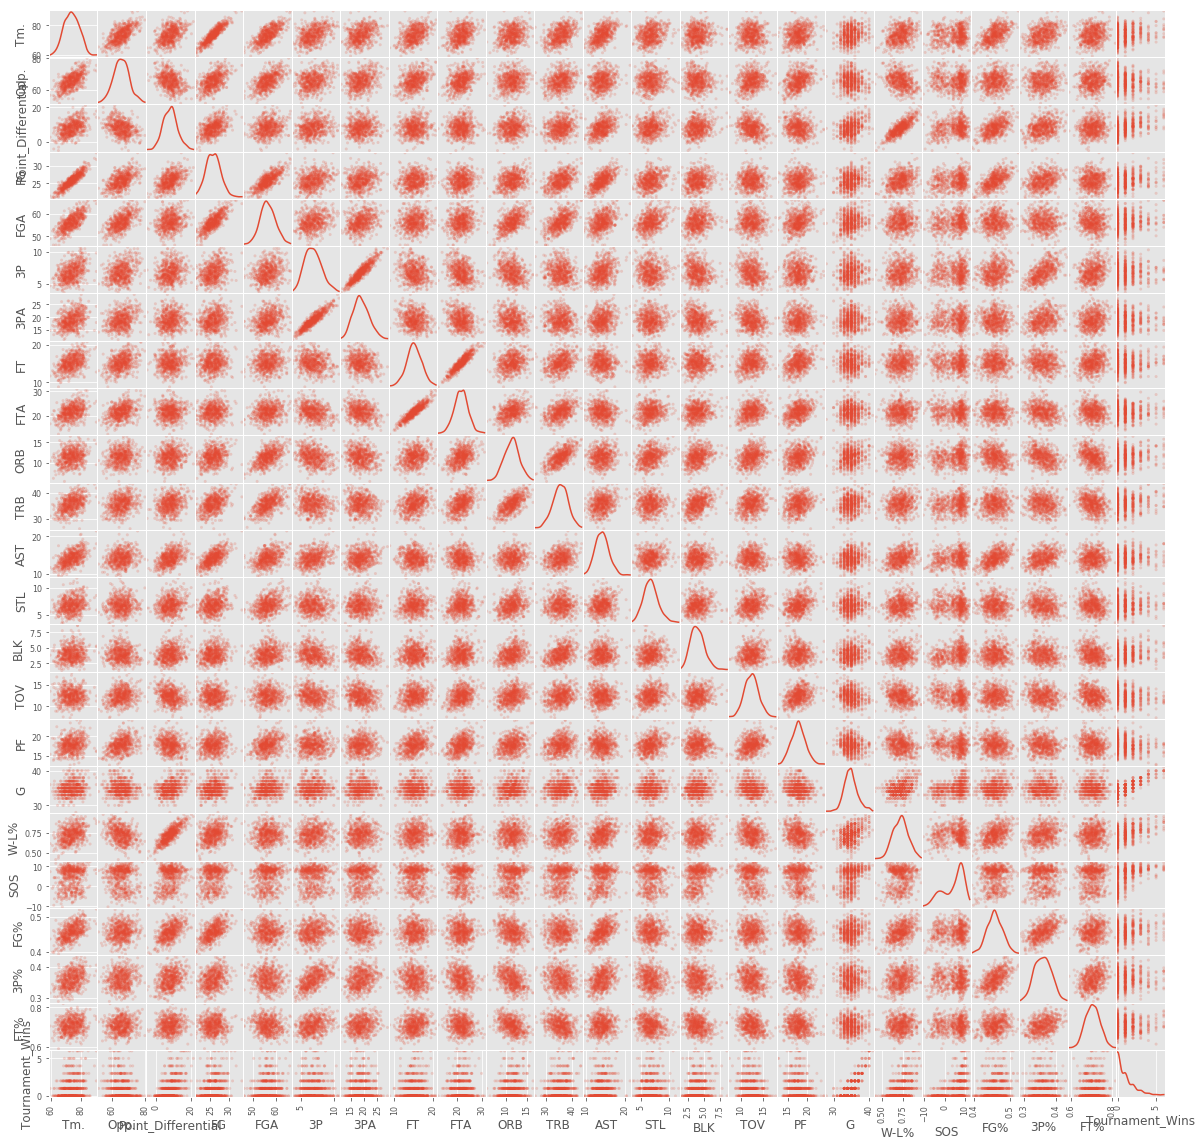

In [76]:
_ = scatter_matrix(df_scatter, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [77]:
predictors = ['Tournament_Wins','W-L%', 'SOS','Point_Diff/G', 'FG%', 'TRB/G', 'TOV/G']

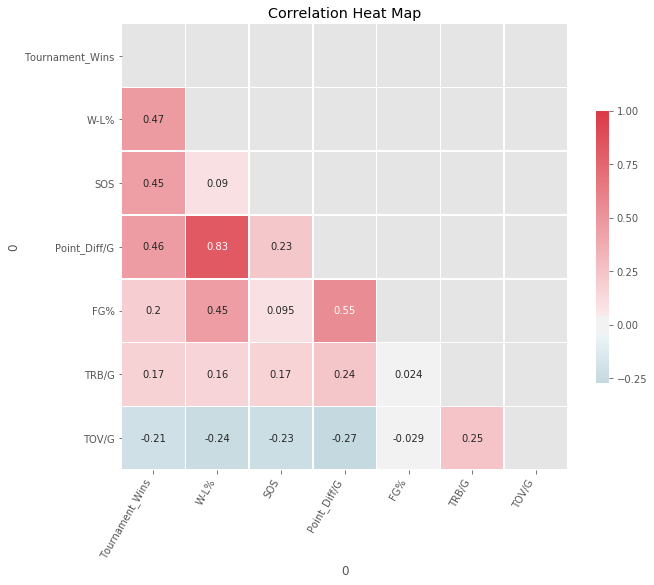

In [78]:
def corr_heat(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=corr.index, yticklabels=corr.columns)
    plt.xticks(rotation=60, ha="right")
    plt.yticks(rotation=0)
    ax.set_title("Correlation Heat Map")
    plt.show()
corr_heat(df_stats[predictors])

# Predictors
    * Winning Percentage
    * Strenth of Schedule
    * FG%
    * TRB
    * Turnovers

In [81]:
predictors = ['W-L%', 'SOS','Point_Differential', 'FG%', 'TRB', 'TOV']

KeyError: 'Tournament_Wins'

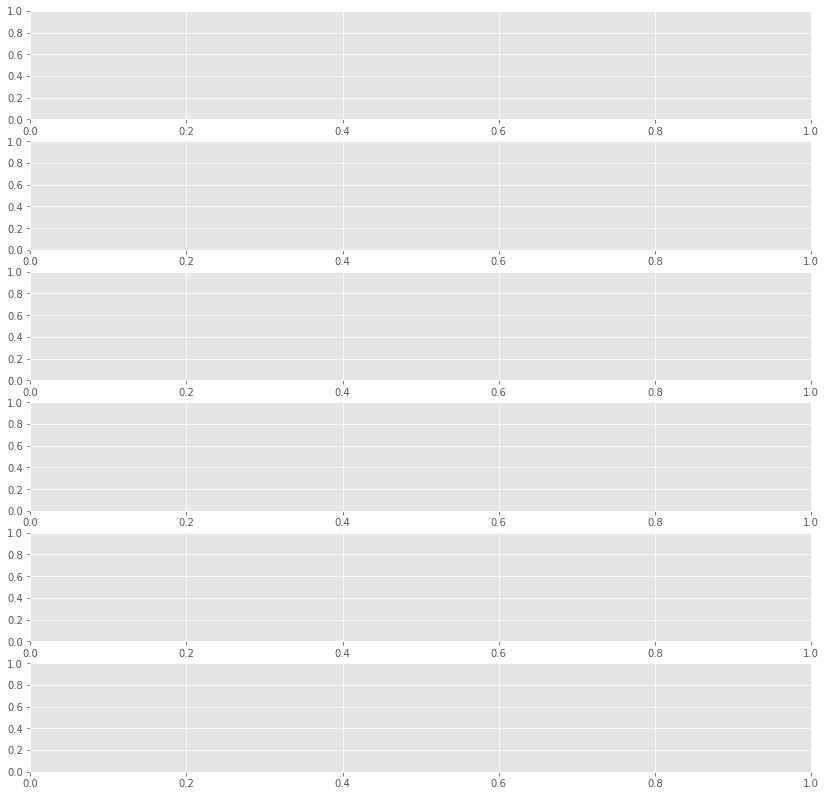

In [82]:
fig, axs = plt.subplots(len(predictors), figsize=(14, 14))

for name, ax in zip(predictors, axs.flatten()):
    plot_univariate_smooth(ax, 
                           df_drop2[name].values.reshape(-1, 1),
                           df_drop2['Tournament_Wins'],
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()

# Non-regularized Train/Test Split

In [ ]:
train_seasons = ['2007-2008','2008-2009','2010-2011','2011-2012','2013-2014','2014-2015','2016-2017']
test_seasons = ['2009-2010','2012-2013','2015-2016']

In [ ]:
def train_split(df, train_list):
    df_train_data = df_drop2.loc[df_drop2['Season'].isin(train_list)]
    return df_train_data
    
def test_split(df, test_list):
    df_test_data = df_drop2.loc[df_drop2['Season'].isin(test_list)]
    return df_test_data

In [ ]:
df_train = train_split(df_drop2, train_seasons)

In [ ]:
df_test = test_split(df_drop2, test_seasons)

In [ ]:
df_train.shape, df_test.shape

In [ ]:
train_X_data = df_train[['W-L%', 'SOS','FG%','TRB', 'TOV']]
train_y_data = df_train['Tournament_Wins']
test_X_data = df_test[['W-L%', 'SOS', 'FG%','TRB', 'TOV']]
test_y_data = df_test['Tournament_Wins']

# Non Regularized Linear Regression

In [ ]:
NCAA_model = LinearRegression()
NCAA_model.fit(train_x_data, train_y_data)

In [ ]:
NCAA_model.intercept_

In [ ]:
NCAA_model.coef_

In [ ]:
#train_tournament_wins_predictions = NCAA_model.predict(train_x_data)
#test_tournament_wins_predictions = NCAA_model.predict(test_y_data)

In [ ]:
tournament_wins_predictions.max(), tournament_wins_predictions.min()

In [ ]:
np.sqrt(mean_squared_error(train_y_data, tournament_wins_predictions))

# Regularized Test/Train Split, Standardization

In [ ]:
df_stats.columns

In [1177]:
train_seasons = ['2007-2008','2008-2009','2010-2011','2011-2012','2013-2014','2014-2015','2016-2017']
test_seasons = ['2009-2010','2012-2013','2015-2016']
X_var = ['Tm./G', 'Opp./G', 'Point_Diff/G', 'FG/G', 'FGA/G', '3P/G', '3PA/G',
       'FT/G', 'FTA/G', 'ORB/G', 'TRB/G', 'AST/G', 'STL/G', 'BLK/G', 'TOV/G',
       'PF/G', 'W-L%', 'SOS', 'FG%', '3P%', 'FT%']
y_var = 'Tournament_Wins'

In [1178]:
X_stats = df_stats[X_var]

In [1179]:
def X_train_split(df, train_list):
    df_X_train_data = X_stats.loc[df_stats['Season'].isin(train_list)]
    return df_X_train_data

def y_train_split(df, train_list):
    df_y_train_data = df_stats.loc[df_stats['Season'].isin(train_list)]
    return df_y_train_data
    
def X_test_split(df, test_list):
    df_test_X_data = X_stats.loc[df_stats['Season'].isin(test_list)]
    return df_test_X_data

def y_test_split(df, test_list):
    df_y_test_data = df_stats.loc[df_stats['Season'].isin(test_list)]
    return df_y_test_data

In [1180]:
df_X_train = X_train_split(X_stats, train_seasons)
df_y_train = y_train_split(df_stats['Tournament_Wins'], train_seasons)
df_X_test = X_test_split(X_stats, test_seasons)
df_y_test = y_test_split(df_stats['Tournament_Wins'], test_seasons)

In [1181]:
df_X_train.shape, df_y_train.shape, df_X_test.shape, df_y_test.shape

((448, 21), (448, 25), (192, 21), (192, 25))

In [1182]:
X_train, y_train, X_test, y_test = df_X_train[X_var], df_y_train[y_var], df_X_test[X_var], df_y_test[y_var]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((448, 21), (448,), (192, 21), (192,))

In [1183]:
#Standardize X_train 
standardizer = StandardScaler()
standardizer.fit(X_train)
X_train_standardized = pd.DataFrame(standardizer.transform(X_train), index=X_train.index, columns=X_train.columns)

In [1184]:
#Standardize X_test 
standardizer = StandardScaler()
standardizer.fit(X_test)
X_test_standardized = pd.DataFrame(standardizer.transform(X_test), index=X_test.index, columns=X_test.columns)


In [1185]:
X_train_standardized.shape, y_train.shape, X_test_standardized.shape, y_test.shape

((448, 21), (448,), (192, 21), (192,))

# Ridge Regression

In [1186]:
ridge = Ridge(alpha=0.5)
ridge.fit(X_train_standardized, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [1187]:
def rss(y, y_hat):
    return np.mean((y  - y_hat)**2)

In [1188]:
#MSE train data
preds = ridge.predict(X_train_standardized)
mse = rss(y_train, preds)
print("MSE for Ridge(alpha=0.5): {:2.2f}".format(mse))

MSE for Ridge(alpha=0.5): 1.01


In [1189]:
#MSE test data
preds = ridge.predict(X_test_standardized)
mse = rss(y_test, preds)
print("MSE for Ridge(alpha=0.5): {:2.2f}".format(mse))

MSE for Ridge(alpha=0.5): 1.22


In [1190]:
def cv(X, y, base_estimator, n_folds, random_seed=154):
    
    kf = KFold(n_splits=n_folds, random_state=random_seed)
    test_cv_errors, train_cv_errors = np.empty(n_folds), np.empty(n_folds)
    for idx, (train, test) in enumerate(kf.split(X_train)):
        # Split into train and test
        X_cv_train, y_cv_train = X[train], y[train]
        X_cv_test, y_cv_test = X[test], y[test]
        # Standardize data.
        standardizer = XyScaler()
        standardizer.fit(X_cv_train, y_cv_train)
        X_cv_train_std, y_cv_train_std = standardizer.transform(X_cv_train, y_cv_train)
        X_cv_test_std, y_cv_test_std = standardizer.transform(X_cv_test, y_cv_test)
        # Fit estimator
        estimator = clone(base_estimator)
        estimator.fit(X_cv_train_std, y_cv_train_std)
        # Measure performance
        y_hat_train = estimator.predict(X_cv_train_std)
        y_hat_test = estimator.predict(X_cv_test_std)
        # Calclate the error metrics
        train_cv_errors[idx] = rss(y_cv_train_std, y_hat_train)
        test_cv_errors[idx] = rss(y_cv_test_std, y_hat_test)
    return train_cv_errors, test_cv_errors

In [1191]:
n_folds = 10
train_cv_errors, test_cv_errors = cv(X_train_standardized.values, y_train.values, 
                                     Ridge(alpha=0.5), n_folds=n_folds)

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

In [1192]:
print("Training CV error: {:2.2f}".format(train_cv_errors.mean()))
print("Test CV error: {:2.2f}".format(test_cv_errors.mean()))

Training CV error: 0.56
Test CV error: 0.61


In [1193]:
def train_at_various_alphas(X, y, model, alphas, n_folds=10, **kwargs):
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_fold_errors, test_fold_errors = cv(X, y, model(alpha=alpha, **kwargs), n_folds=n_folds)
        cv_errors_train.loc[:, alpha] = train_fold_errors
        cv_errors_test.loc[:, alpha] = test_fold_errors
    return cv_errors_train, cv_errors_test

In [1194]:
ridge_alphas = np.logspace(-2, 4, num=250)

ridge_cv_errors_train, ridge_cv_errors_test = train_at_various_alphas(
    X_train_standardized.values, y_train.values, Ridge, ridge_alphas)

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [1195]:
ridge_cv_errors_train.head()

,0.01,0.01057052081,0.0111735910195,0.0118110676394,0.0124849136271,0.0131972039306,0.0139501318782,0.0147460159321,0.0155873068275,0.0164765951193,...,6069.21510641,6415.47645827,6781.49274083,7168.39101399,7577.36263877,8009.66694581,8466.63511319,8949.67426547,9460.2718066,10000.0
0,0.571228,0.571236,0.571244,0.571251,0.571259,0.571266,0.571273,0.571280,0.571287,0.571294,...,0.888387,0.892893,0.897277,0.901536,0.905670,0.909678,0.913560,0.917317,0.920947,0.924454
1,0.553318,0.553326,0.553335,0.553343,0.553351,0.553359,0.553367,0.553374,0.553382,0.553389,...,0.883815,0.888516,0.893088,0.897530,0.901840,0.906018,0.910064,0.913978,0.917760,0.921413
2,0.557644,0.557655,0.557665,0.557675,0.557685,0.557695,0.557704,0.557713,0.557721,0.557730,...,0.882183,0.886904,0.891498,0.895965,0.900303,0.904512,0.908591,0.912539,0.916358,0.920048
3,0.546250,0.546257,0.546264,0.546270,0.546276,0.546283,0.546289,0.546294,0.546300,0.546306,...,0.873069,0.878108,0.883016,0.887791,0.892433,0.896938,0.901308,0.905540,0.909637,0.913597
4,0.560649,0.560650,0.560651,0.560652,0.560653,0.560655,0.560656,0.560658,0.560660,0.560662,...,0.882280,0.886976,0.891549,0.895996,0.900317,0.904509,0.908574,0.912510,0.916317,0.919998


In [1196]:
ridge_mean_cv_errors_train = ridge_cv_errors_train.mean(axis=0)
ridge_mean_cv_errors_test = ridge_cv_errors_test.mean(axis=0)

In [1197]:
def get_optimal_alpha(mean_cv_errors_test):
    alphas = mean_cv_errors_test.index
    optimal_idx = np.argmin(mean_cv_errors_test.values)
    optimal_alpha = alphas[optimal_idx]
    return optimal_alpha

ridge_optimal_alpha = get_optimal_alpha(ridge_mean_cv_errors_test)

Text(0,0.5,'MSE')

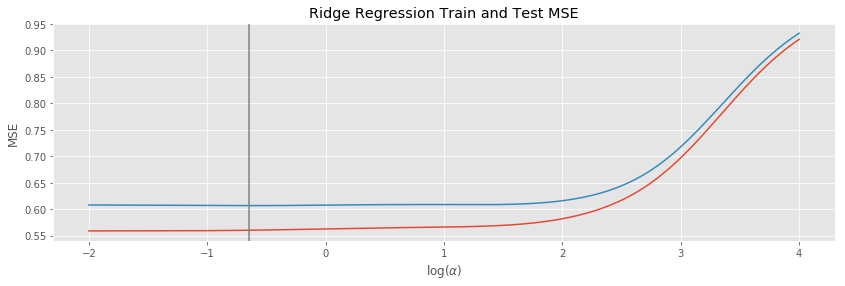

In [1198]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np.log10(ridge_alphas), ridge_mean_cv_errors_train)
ax.plot(np.log10(ridge_alphas), ridge_mean_cv_errors_test)
ax.axvline(np.log10(ridge_optimal_alpha), color='grey')
ax.set_title("Ridge Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")

In [1199]:
ridge_optimal_alpha

0.22356179624047798

# Lasso Regression

In [1200]:
lasso_alphas = np.logspace(-3, 1, num=250)

lasso_cv_errors_train, lasso_cv_errors_test = train_at_various_alphas(
    X_train_standardized.values, y_train.values, Lasso, lasso_alphas, max_iter=5000)

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/util

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [1201]:
lasso_cv_errors_test.shape

(10, 250)

Text(0,0.5,'MSE')

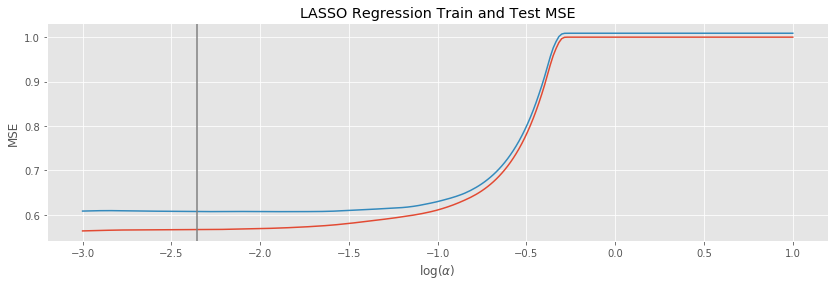

In [1202]:
lasso_mean_cv_errors_train = lasso_cv_errors_train.mean(axis=0)
lasso_mean_cv_errors_test = lasso_cv_errors_test.mean(axis=0)

lasso_optimal_alpha = get_optimal_alpha(lasso_mean_cv_errors_test)
    
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_train)
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_test)
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.set_title("LASSO Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")


In [1203]:
lasso_models = []

for alpha in lasso_alphas:
    scaler = XyScaler()
    scaler.fit(X_train.values, y_train.values)
    X_train_std, y_train_std = scaler.transform(X_train.values, y_train.values)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_std, y_train_std)
    lasso_models.append(lasso)

/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/davidlacharite/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0,0.5,'Standardized Coefficient')

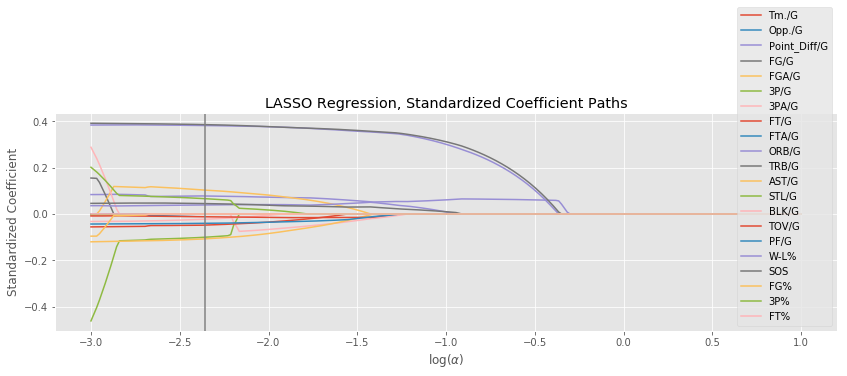

In [1204]:
paths = pd.DataFrame(np.empty(shape=(len(lasso_alphas), len(X_train.columns))),
                     index=lasso_alphas, columns=X_train.columns)

for idx, model in enumerate(lasso_models):
    paths.iloc[idx] = model.coef_
    
fig, ax = plt.subplots(figsize=(14, 4))
for column in X_train.columns:
    path = paths.loc[:, column]
    ax.plot(np.log10(lasso_alphas), path, label=column)
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.legend(loc='lower right')
ax.set_title("LASSO Regression, Standardized Coefficient Paths")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("Standardized Coefficient")

In [1205]:
lasso_optimal_alpha

0.0043910691980449945

# Model Comparison

In [1206]:
final_ridge = Ridge(alpha=ridge_optimal_alpha).fit(X_train_standardized, y_train)
final_lasso = Lasso(alpha=lasso_optimal_alpha).fit(X_train_standardized, y_train)
final_lr = LinearRegression().fit(X_train_std, y_train_std)

In [1207]:
final_ridge_RMSE = np.sqrt(mean_squared_error(y_test, final_ridge.predict(X_test_standardized)))
final_lasso_RMSE = np.sqrt(mean_squared_error(y_test, final_lasso.predict(X_test_standardized)))
final_lr_RMSE = np.sqrt(mean_squared_error(test_y_data, NCAA_model.predict(test_X_data)))

In [1208]:
print("Final Ridge RMSE: {:2.3f}".format(final_ridge_rss))
print("Final Lasso RMSE: {:2.3f}".format(final_lasso_rss))
print("Final Linear Regression RMSE: {:2.3f}".format(final_lr_RMSE))

Final Ridge RMSE: 1.108
Final Lasso RMSE: 1.096
Final Linear Regression RMSE: 1.100
